In [1]:
import phenomxpy.phenomt as phenomt
from phenomxpy.utils import SecondtoMass, AmpSItoNR, m1ofq, m2ofq, AmpNRtoSI, HztoMf, MftoHz
from pycbc import waveform, types
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

/home/suzanne/anaconda3/envs/phenomxpy/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


# Mass independent waveforms

## How to create mass independence?
To produce identical mass independent waveforms, the `compute_polarisations` function needs to be run without distance and/or total_mass parameters. Running this function without distance and mass specifications will output polarisations in geometric units. In addition the f_ref and f_min (and t in case of specification) need to be converted to mass independent parameters. This can be done by using the `HztoMf` function to first convert to geometric frequency. Because the frequency always needs to be defined in units of Hz, immediate specification of the geometric frequency is not possible. Hence, to produce identical mass idependent waveforms starting with different masses, the geometric frequency needs to be converted back to Hz after scaling relative to the reference total mass, using `MftoHz`. 

For example:  
Use reference total_mass = 50 $M_{\odot}$  
`# convert to geometric frequency`  
`f_geom = HztoMf(f_ref, total_mass)`  

`# to get equal frequency values for different mass systems now scale to new mass frequency in Hz`  
`total_mass2 = 30`  
` f_ref2 = MftoHz(f_geom, total_mass2)` 



## Phase offsets
### Understanding the Origin of Phase Offsets in Surrogate Waveforms

Phase offsets arise naturally when extracting or modeling waveform phases because:

- The **gravitational wave phase is defined modulo \(2\pi\)**, so there is an inherent ambiguity of an integer multiple of \(2\pi\).
- When generating or reconstructing waveforms, the **starting phase can differ by a constant amount** due to differences in initial conditions or numerical procedures.
- The **phase is a relative quantity**, and its absolute zero point is arbitrary — physically only *phase differences* matter.
- In eccentric waveforms, the **complex orbital dynamics** cause more pronounced and less predictable phase shifts than in circular cases.
- Numerical procedures like **unwrap and interpolation** can introduce small offsets, especially when comparing waveforms at different parameters.

Thus, these phase offsets are not errors but rather **expected gauge freedoms** in waveform modeling.

---

### How to Handle Phase Offsets

- Treat the phase offset as a **free parameter** during parameter estimation — it can be absorbed by time and phase shifts.
- When evaluating surrogate accuracy, use **mismatch/overlap metrics maximized over phase and time shifts**.
- Avoid forcing a fixed global phase alignment in the surrogate training to maintain generality.

This approach ensures the surrogate accurately represents the physical waveform family without artifacts from arbitrary phase conventions.


In [2]:
times = np.linspace(-10000, 0, num=10000)  # times in seconds

def amplitude(hplus_SI, hcross_SI, geometric_units=True, distance=None, total_mass=None):
    """
    Calculate the amplitude from the plus and cross polarizations.
    If geometric_units is True, the amplitude is returned in geometric units.
    """
    amp_NR = np.abs(hplus_SI - 1j * hcross_SI)
    
    if geometric_units:
        return amp_NR
    else:
        return AmpNRtoSI(amp_NR, distance, total_mass)

def phase(hplus, hcross):
    """
    Calculate the phase from the plus and cross polarizations. Unitless.
    """
    phase = np.unwrap(np.arctan2(hcross, hplus))
    phase -= phase[0] # Normalize phase to start at zero, correcting for the initial phase offset.
    
    return phase


def polarisations(phase, amplitude, geometric_units=True, distance=None, total_mass=None):
    """
    Calculate the plus and cross polarizations from the phase and amplitude.
    If geometric_units is True, the polarizations are returned in geometric units.
    """
    if geometric_units:
        hplus = amplitude * np.cos(phase)
        hcross = -amplitude * np.sin(phase)
    else:
        hplus = AmpNRtoSI(amplitude, distance, total_mass) * np.cos(phase)
        hcross = AmpNRtoSI(amplitude, distance, total_mass) * np.sin(phase)
    
    return hplus, hcross

In [3]:
def test_phenom(eccmin, total_mass, mass_ratio, distance, f_min=20, f_ref=20, DeltaT=1./4096., inclination=0., phiRef=0., geometric_units=False):

    mass1 = m1ofq(mass_ratio, total_mass)
    mass2 = m2ofq(mass_ratio, total_mass)

    total_mass2 = total_mass + 20
    distance2 = distance + 200
            


    # normal phenomTE
    times = np.linspace(-10000, 0, num=1000)  # times in seconds
    phen = phenomt.PhenomTE(
    mode=[2,2],
    times=times,
    eccentricity=eccmin,  
    total_mass=total_mass,
    distance=distance,                
    f_ref=f_ref,                   
    f_lower=f_min,
    phiRef=np.pi/2 - phiRef, # different -i and +i conventions for polarisation definitions compared to eccentricTD.
    inclination=inclination)

    # phen = phenomt.PhenomTE(mode=[2,2], times=times, eccentricity=eccmin, f_ref=f_min, f_lower=f_ref, phiRef=np.pi/2 - phiRef, inclination=inclination)
    phen.compute_polarizations(times=times)

    # Get reference frequencies for reference PhenomTE
    geom_freq = HztoMf(phen.pWF.f_lower, total_mass)
    f_ref_ref = MftoHz(geom_freq, total_mass2)
    f_min_ref = f_ref_ref

    # Reference PhenomTE
    phen_ref = phenomt.PhenomTE(
    mode=[2,2],
    times=times,
    eccentricity=eccmin, 
    total_mass=total_mass2,
    distance=distance2,                
    f_ref=f_ref_ref,                   
    f_lower=f_min_ref,               
    phiRef=np.pi/2 - phiRef,
    inclination=inclination)

    phen_ref.compute_polarizations(times=times)

    return times, phen, phen_ref


In [ ]:
times, phen, phen_ref = test_phenom(eccmin=0.2, total_mass=50, mass_ratio=1, distance=200, f_min=10, f_ref=10)

In [ ]:
fig_compare_hp = plt.figure(figsize=(10, 6))
# hp
plt.plot(times, phen.hp, label='PhenomTE $h_+$', alpha=0.7)
plt.plot(times, phen_ref.hp, label='PhenomTE $h_+$ SI ref computed', alpha=0.7)
plt.ylabel('$h_+$')
plt.xlabel('time (M)')
plt.legend()

fig_compare_hc = plt.figure(figsize=(10, 6))
#hc
plt.plot(times, phen.hc, label='PhenomTE $h_{\times}$', alpha=0.7)
plt.plot(times, phen_ref.hc, label='PhenomTE $h_{\times}$ SI ref', alpha=0.7)
plt.ylabel('$h_{\times}$')
plt.xlabel('time (M)')
plt.legend()


In [ ]:

fig_compare_phases = plt.figure(figsize=(10, 6))    
# phases
plt.plot(times, phase(phen.hp, phen.hc), label='PhenomTE phase')
plt.plot(times, phase(phen_ref.hp, phen_ref.hc), label='PhenomTE phase ref')
plt.ylabel('$\phi$')
plt.xlabel('time (M)')
plt.legend()


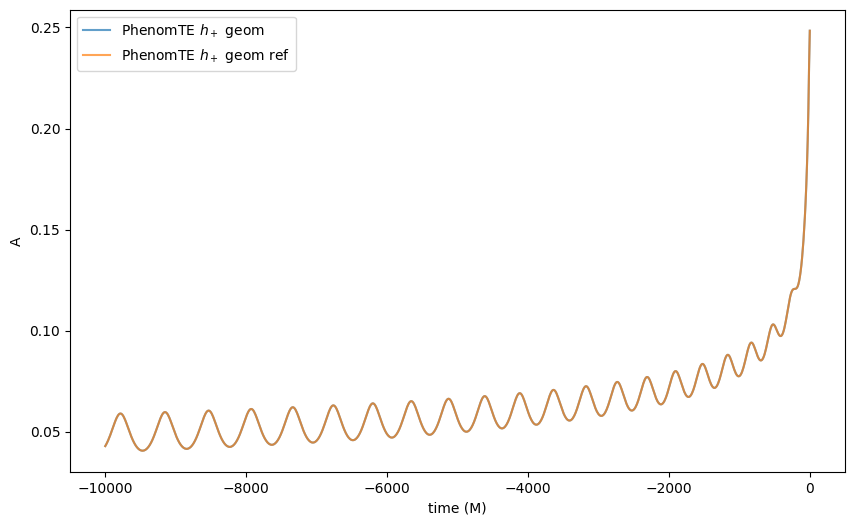

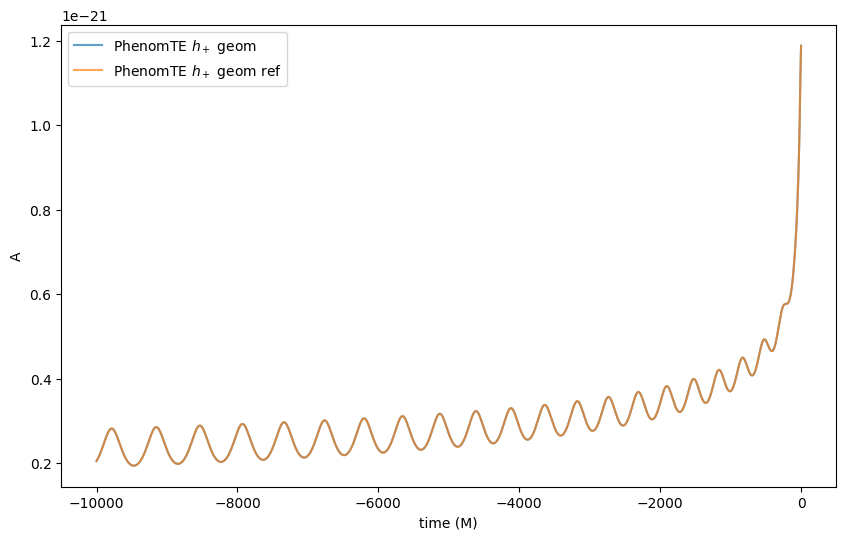

In [7]:
fig_compare_amplitudes_geom = plt.figure(figsize=(10, 6))
# amplitudes
plt.plot(times, amplitude(phen.hp, phen.hc), label='PhenomTE $h_+$ geom', alpha=0.7)
plt.plot(times, amplitude(phen_ref.hp, phen_ref.hc), label='PhenomTE $h_+$ geom ref', alpha=0.7)
plt.ylabel('A')
plt.xlabel('time (M)')
plt.legend()

fig_compare_amplitudes_SI = plt.figure(figsize=(10, 6))
# amplitudes
plt.plot(times, amplitude(phen.hp, phen.hc, geometric_units=False, distance=500, total_mass=50), label='PhenomTE $h_+$ geom', alpha=0.7)
plt.plot(times, amplitude(phen_ref.hp, phen_ref.hc, geometric_units=False, distance=500, total_mass=50), label='PhenomTE $h_+$ geom ref', alpha=0.7)
plt.ylabel('A')
plt.xlabel('time (M)')
plt.legend()

# Mass dependent waveforms


ValueError: x and y must have same first dimension, but have shapes (10000,) and (1000,)

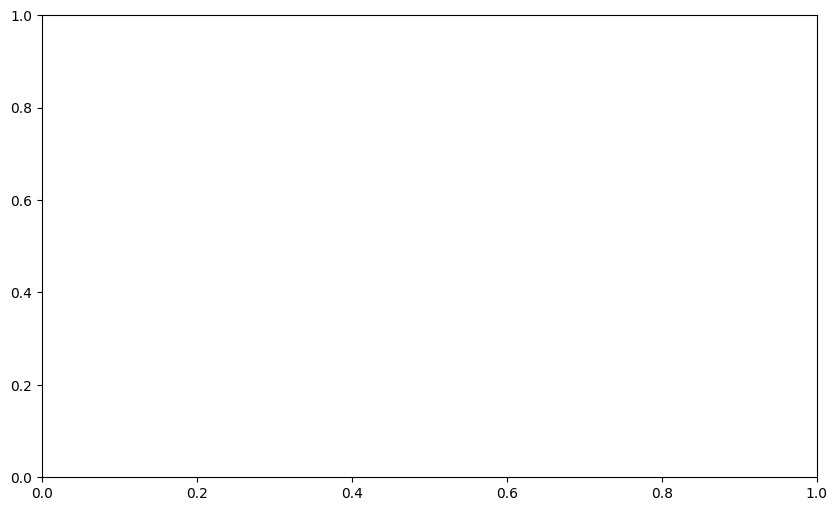

In [8]:
times = np.linspace(-10000, 0, num=10000)  # times in seconds

eccmin=0.2
total_mass=50
mass_ratio=1
distance=200
f_min=10
f_ref=10
phiRef=0.
inclination=0.

phen_SI = phenomt.PhenomTE(
mode=[2,2],
times=times,
eccentricity=eccmin,  
total_mass=total_mass,
distance=distance,                
f_ref=f_ref,                   
f_lower=f_min,
phiRef=np.pi/2 - phiRef,
inclination=inclination)

# To get the SI polarizations, we need to compute them with the SI parameters, defined in the compute_polarisations function
phen_SI.compute_polarizations(times=times, distance=distance, total_mass=total_mass)


fig_compare = plt.figure(figsize=(10, 6))
# hp
plt.plot(times, AmpNRtoSI(phen.hp, distance, total_mass), label='PhenomTE $h_+$', alpha=0.7)
plt.plot(times, phen_SI.hp, label='PhenomTE $h_+$ SI ', alpha=0.7)
plt.ylabel('$h_+$')
plt.xlabel('time (M)')
plt.legend()


# No total mass specification in class


If the total mass and distance are not specified in the `phenomt.PhenomTE()` object, the function assumes a default value of 60 $M_{\odot}$ to convert `HztoMf(f_min, total_mass)` and `HztoMf(f_lower, total_mass)` to geometric frequency. 

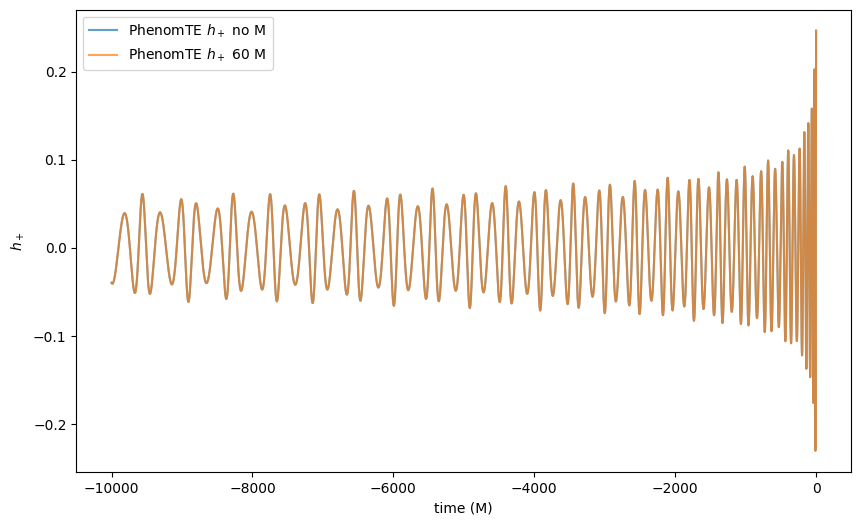

In [9]:
times = np.linspace(-10000, 0, num=10000)  # times in seconds

eccmin=0.2
total_mass=60
mass_ratio=1
distance=200
f_min=10
f_ref=10
phiRef=0.
inclination=0.

phen_60 = phenomt.PhenomTE(
mode=[2,2],
times=times,
eccentricity=eccmin,  
total_mass=total_mass,
distance=distance,                
f_ref=f_ref,                   
f_lower=f_min,
phiRef=np.pi/2 - phiRef,
inclination=inclination)

phen_60.compute_polarizations(times=times)

# No total mass and distance specified in the class, so it assumes a default value of 60 $M_{\odot}$ to convert `HztoMf(f_min, total_mass)` and `HztoMf(f_lower, total_mass)` to geometric frequency.
phen_none = phenomt.PhenomTE(
mode=[2,2],
times=times,
eccentricity=eccmin,                  
f_ref=f_ref,                   
f_lower=f_min,
phiRef=np.pi/2 - phiRef,
inclination=inclination)

phen_none.compute_polarizations(times=times)


fig_compare = plt.figure(figsize=(10, 6))
# hp
plt.plot(times, phen_none.hp, label='PhenomTE $h_+$ no M', alpha=0.7)
plt.plot(times, phen_60.hp, label='PhenomTE $h_+$ 60 M ', alpha=0.7)
plt.ylabel('$h_+$')
plt.xlabel('time (M)')
plt.legend()


# Test eccentric mass independent dataset

In [10]:

eccentricities = np.linspace(0, 0.3, num=500)

hp = np.zeros((len(eccentricities), len(times)))
hc = np.zeros((len(eccentricities), len(times)))    
amps = np.zeros((len(eccentricities), len(times)))
phases = np.zeros((len(eccentricities), len(times)))

for i, ecc in enumerate(eccentricities):
    phen = phenomt.PhenomTE(
        mode=[2,2],
        times=times,
        eccentricity=ecc,                
        f_ref=10,                   
        f_lower=10,
        phiRef=0.,
        inclination=0.)
    
    phen.compute_polarizations(times=times)

    hp[i, :] = phen.hp
    hc[i, :] = phen.hc
    amps[i, :] = amplitude(phen.hp, phen.hc)
    phases[i, :] = phase(phen.hp, phen.hc)

print(phases[0], phases[200])

[0.00000000e+00 2.38884939e-02 4.77778390e-02 ... 3.66779784e+02
 3.67123595e+02 3.67478120e+02] [0.00000000e+00 2.28214962e-02 4.56734938e-02 ... 3.65253688e+02
 3.65597847e+02 3.65952115e+02]


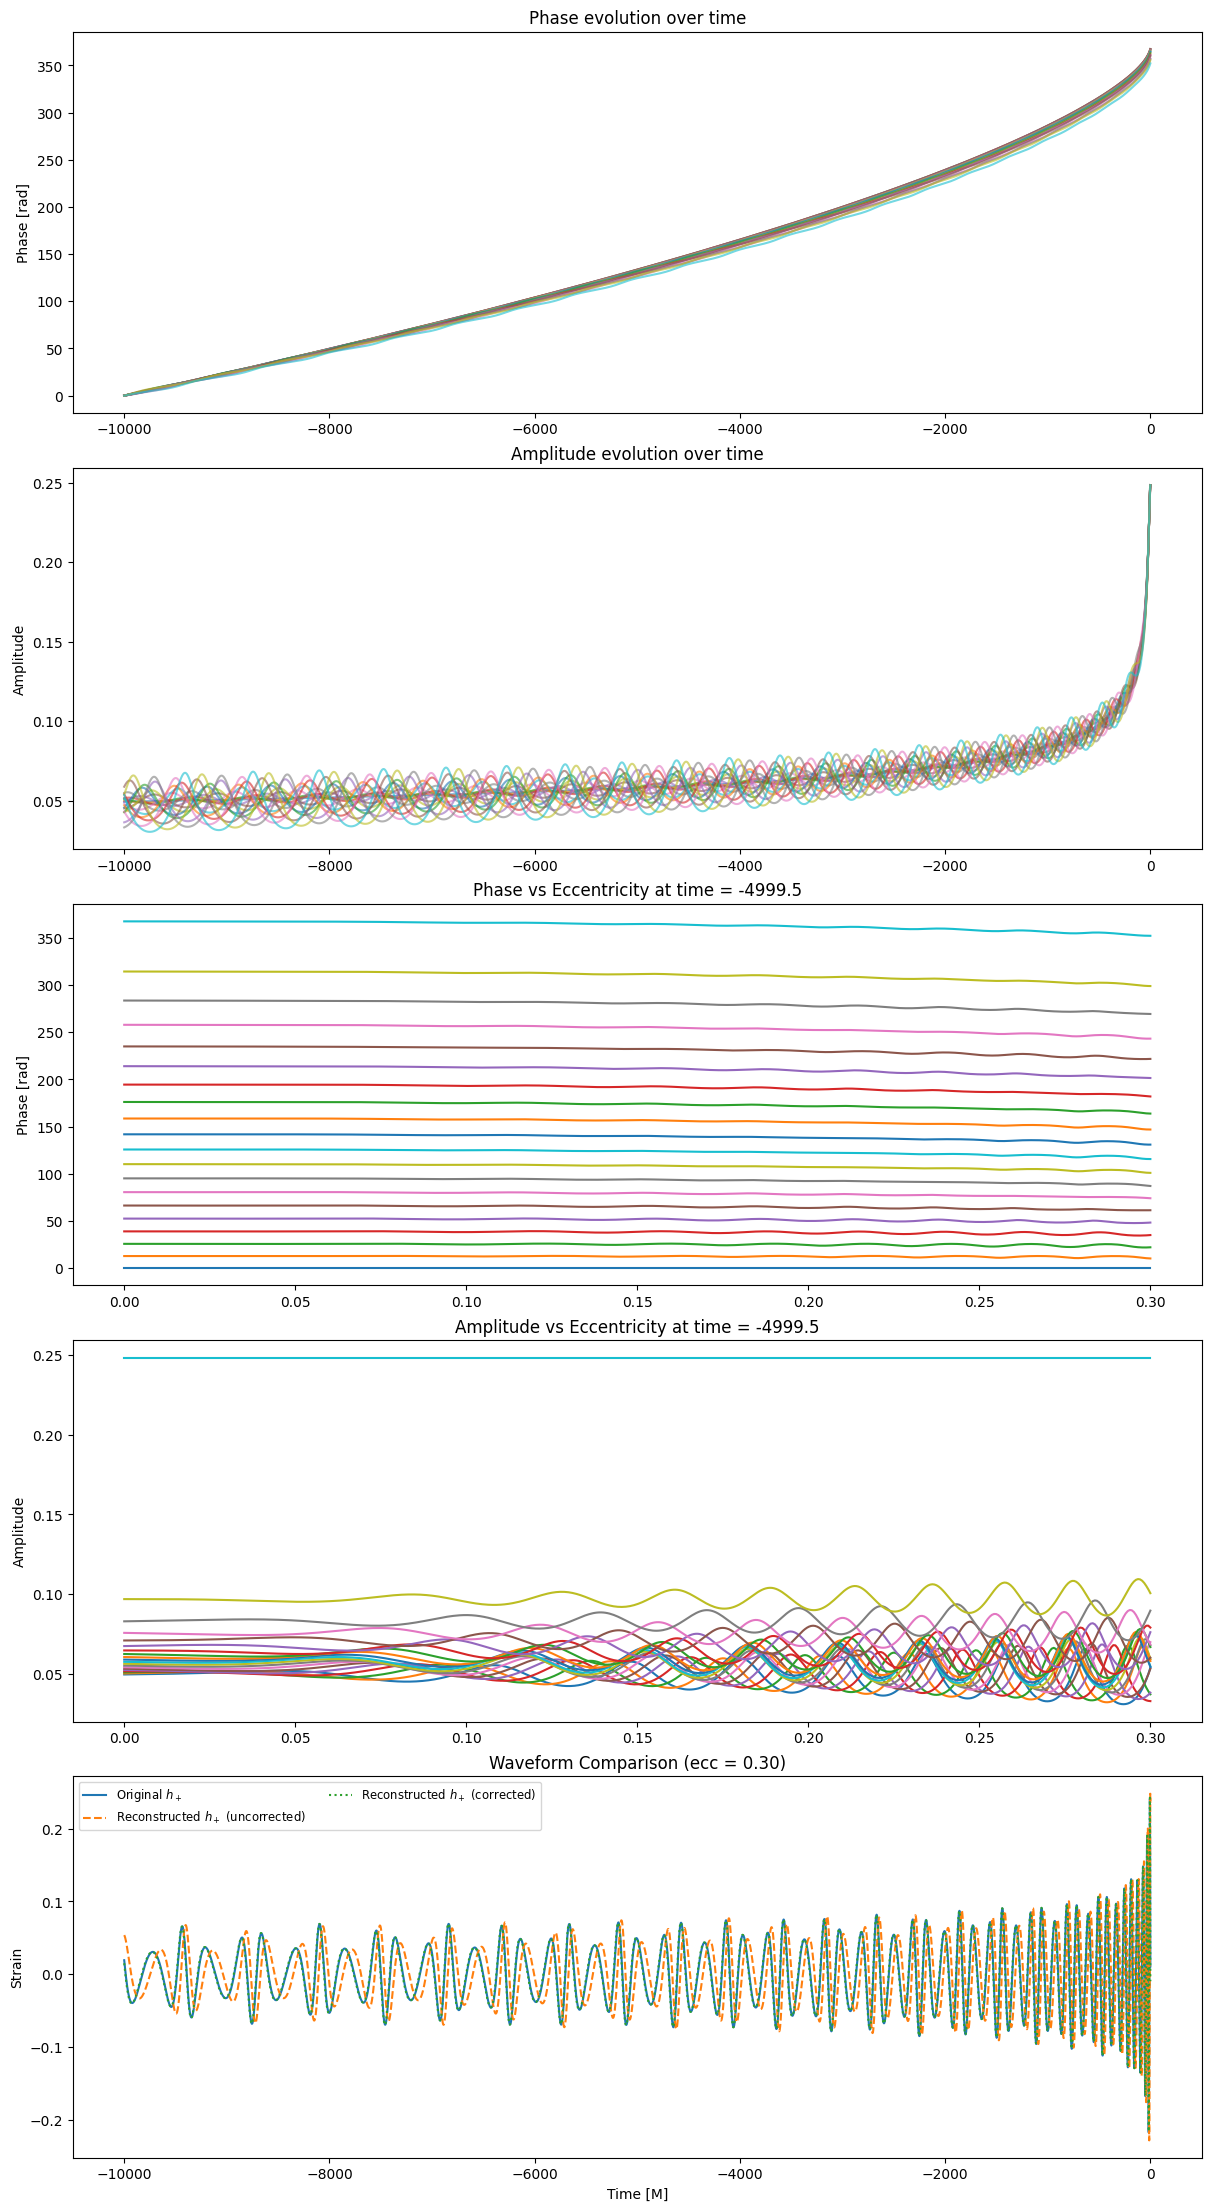

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Choose waveform index and time index for 2D plots
waveform_idx = -1  # last (highest eccentricity)
ref_time_idx = len(times) // 2

# Compute reconstructed polarizations
hplus_rec, hcross_rec = polarisations(phases[waveform_idx], amps[waveform_idx], geometric_units=True)
hp_rec = hplus_rec
hc_rec = hcross_rec

# Combine into complex waveform
h_rec = hp_rec - 1j * hc_rec
h_true = hp[waveform_idx] - 1j * hc[waveform_idx]

# Estimate optimal global phase offset
offset = np.angle(np.vdot(h_true, h_rec))  # <h_true | h_rec>
h_rec_corrected = h_rec * np.exp(1j * offset)

# Decompose again into corrected h+ and hx
hp_rec_corr = h_rec_corrected.real
hc_rec_corr = -h_rec_corrected.imag

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(12, 22), constrained_layout=True)

# 1. Phase vs time
for ecc_idx in np.linspace(0, len(eccentricities)-1, num=20, dtype=int):
    axs[0].plot(times, phases[ecc_idx], alpha=0.6)
axs[0].set_title("Phase evolution over time")
axs[0].set_ylabel("Phase [rad]")

# 2. Amplitude vs time
for ecc_idx in np.linspace(0, len(eccentricities)-1, num=20, dtype=int):
    axs[1].plot(times, amps[ecc_idx], alpha=0.6)
axs[1].set_title("Amplitude evolution over time")
axs[1].set_ylabel("Amplitude")

# 3. Phase vs eccentricity at a specific time point
for time_idx in np.linspace(0, len(times)-1, num=20, dtype=int):
    axs[2].plot(eccentricities, phases[:, time_idx], label=f'time = {times[time_idx]:.1f}')
axs[2].set_title(f"Phase vs Eccentricity at time = {times[ref_time_idx]:.1f}")
axs[2].set_ylabel("Phase [rad]")

# 4. Amplitude vs eccentricity at a specific time point
for time_idx in np.linspace(0, len(times)-1, num=20, dtype=int):
    axs[3].plot(eccentricities, amps[:, time_idx], label=f'time = {times[time_idx]:.1f}')
axs[3].set_title(f"Amplitude vs Eccentricity at time = {times[ref_time_idx]:.1f}")
axs[3].set_ylabel("Amplitude")

# 5. Comparison of original vs reconstructed hp, hc
axs[4].plot(times, hp[waveform_idx], label='Original $h_+$', color='C0')
axs[4].plot(times, hp_rec, '--', label='Reconstructed $h_+$ (uncorrected)', color='C1')
axs[4].plot(times, hp_rec_corr, ':', label='Reconstructed $h_+$ (corrected)', color='C2')

# axs[4].plot(times, hc[waveform_idx], label='Original $h_\\times$', color='C3')
# axs[4].plot(times, hc_rec, '--', label='Reconstructed $h_\\times$ (uncorrected)', color='C4')
# axs[4].plot(times, hc_rec_corr, ':', label='Reconstructed $h_\\times$ (corrected)', color='C5')

axs[4].set_title(f"Waveform Comparison (ecc = {eccentricities[waveform_idx]:.2f})")
axs[4].set_xlabel("Time [M]")
axs[4].set_ylabel("Strain")
axs[4].legend(fontsize='small', ncol=2)

plt.show()


## Eccentric limits


Since the inspiral phase is calculatd using the PN-expansion, this means that for higher eccentricities (higher velocities, closer to NR) the accuracy of the waveforms decreases. 

The figures below show the geometric frequency of the waveform for increasing eccentricity (further away from the merger means higher eccentricity and thus larger inaccuracy) in comparison with the circular ISCO cut-off frequency and their polarisations for comparison. 

<table>
  <tr>
    <td><img src="Images/ISCO/after_ISCO_vs_Mf_M=60_e=0.1_f_lower=10.svg?v=1" width="500"></td>
    <td><img src="Images/Polarisations/Polarisations_M=60_ecc=0.1.svg?v=1" width="500"></td>
  </tr>
  <tr>
    <td><img src="Images/ISCO/after_ISCO_vs_Mf_M=60_e=0.24_f_lower=10.svg?v=1" width="500"></td>
    <td><img src="Images/Polarisations/Polarisations_M=60_ecc=0.24.svg?v=1" width="500"></td>
  </tr>
  <tr>
    <td><img src="Images/ISCO/after_ISCO_vs_Mf_M=60_e=0.27_f_lower=10.svg?v=1" width="500"></td>
    <td><img src="Images/Polarisations/Polarisations_M=60_ecc=0.27.svg?v=1" width="500"></td>
  </tr>
  <tr>
    <td><img src="Images/ISCO/after_ISCO_vs_Mf_M=60_e=0.32_f_lower=10.svg?v=1" width="500"></td>
    <td><img src="Images/Polarisations/Polarisations_M=60_ecc=0.32.svg?v=1" width="500"></td>
  </tr>
  <tr>
    <td><img src="Images/ISCO/after_ISCO_vs_Mf_M=60_e=0.35_f_lower=10.svg?v=1" width="500"></td>
    <td><img src="Images/Polarisations/Polarisations_M=60_ecc=0.35.svg?v=1" width="500"></td>
  </tr>
</table>



## Truncate waveform at ISCO

ISCO cut-off is calculated using:

after ISCO cut-off:

![alt text](Images/Residuals/Residuals_eccentric_evolv_phase_M=60_ecc_list=[0.0_0.2_N=40]_f_lower=10_f_ref=20.png)

## Check mass-dependent vs mass-independent waveforms


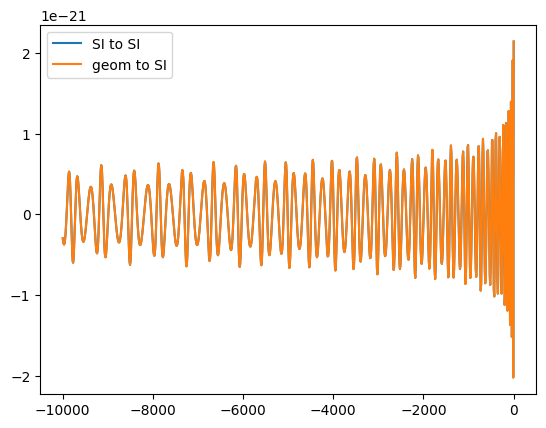

In [11]:
def compare_SI_vs_NR_phenom(eccmin, total_mass, distance, f_min=20, f_ref=20, DeltaT=1./4096., inclination=0., phiRef=0., geometric_units=False):

            


    # normal phenomTE
    times = np.linspace(-10000, 0, num=1000)  # times in seconds
    phen_NR = phenomt.PhenomTE(
    mode=[2,2],
    times=times,
    eccentricity=eccmin,  
    total_mass=total_mass,
    distance=distance,                
    f_ref=f_ref,                   
    f_lower=f_min,
    phiRef=np.pi/2 - phiRef, # different -i and +i conventions for polarisation definitions compared to eccentricTD.
    inclination=inclination)

    # phen = phenomt.PhenomTE(mode=[2,2], times=times, eccentricity=eccmin, f_ref=f_min, f_lower=f_ref, phiRef=np.pi/2 - phiRef, inclination=inclination)
    phen_NR.compute_polarizations(times=times)

    # Get reference frequencies for reference PhenomTE
    

    # Reference PhenomTE
    phen_SI = phenomt.PhenomTE(
    mode=[2,2],
    times=times,
    eccentricity=eccmin, 
    total_mass=total_mass,
    distance=distance,                
    f_ref=f_ref,                   
    f_lower=f_min,               
    phiRef=np.pi/2 - phiRef,
    inclination=inclination)

    phen_SI.compute_polarizations(times=times, distance=distance, total_mass=total_mass)

    fig_compare_NR_vs_SI = plt.figure()
    plt.plot(times, phen_SI.hp, label='SI to SI')
    plt.plot(times, AmpNRtoSI(phen_NR.hp, distance, total_mass), label='geom to SI')
    plt.legend()
    plt.show()



compare_SI_vs_NR_phenom(0.2, 40, 200)